<H1><center>Earthquake predictions in Mexico<br>(Pre-processing & Modelling)</center></H1>

In the previous steps we were able to identify some important information about our data. Basically we identified the following&colon;<br><br>
&nbsp;&nbsp;&nbsp;a) Stronger earthquakes in magnitude, occur (in general) closer to the surface (lower value of depth)<br>
&nbsp;&nbsp;&nbsp;b) By analyzing different years where a big event occurred, we could identify similar patterns where magnitude in events throughout the year was increasing slowly until the main earthquake happened<br>
&nbsp;&nbsp;&nbsp;c) There is a tendency that the bigger earthquakes take place around the last quarter of the year<br>
&nbsp;&nbsp;&nbsp;d) Location is very important due to the proximity to tectonic plates (pacific coast). It should be interesting to add a feature considering these plates<br>
&nbsp;&nbsp;&nbsp;e) When comparing areas (states) with high seismic activity, we were able to identify specifically which ones were the ones with the highest frequency of events<br>

Now we will focus in adding any other features that may seem to give value to the model we are going to train. Since the goal of this project is to try to estimate the time-to-event, we are going to handle it as a survival analysis. Due to this, we will need two columns in our 'y' set, as follows&colon;<br><br>
&nbsp;&nbsp;&nbsp;a) The 'Status' binary categorical column indicating the presence of the event. We will consider any event of magnitude greater than or equal to 6.0 as '1' and any other event as '0'<br>
&nbsp;&nbsp;&nbsp;b) The 'Time to event' numerical (continuous) column indicating the time passed until the event happened. For this part, we will need to think about how are we going to consider the starting point to calculate the time for every event. Since this is no ordinary use for the survival analysis, we will try to adapt our case to it. Let's explain a little bit about survival analysis and how we are going to handle times to event.

In regular survival analysis we have a number of participants in a 'study' (i.e. number of patients in a clinical study). All the participants join the study at certain point and we record the time that passed since they joined (starting point) until the event in interest happened (i.e. death of the patient) or the patient's data becomes censored. The patient's data becomes censored when we can no longer determine if the event really happened or not. For example, follow up on some patient could be lost by any reason (they moved to another city) or the time of the study could be finished before the event happens, so we don't know what happened after this point. In all of these cases, we handle the data as censored data.

In our case, we will consider every earthquake as a participant. Also, we will consider every earthquake with a magnitude less than 6.0, a censored participant (class 0) and the rest of the earhquakes as uncensored participants (class 1) where the event happened.<br><br>

Now, regarding the times to event, let's see Fig.1 to illustrate it better. In the following image (Fig.1), on the left side, we can see that there are different points when a participant (participants A to H) joined the study. In our case, every starting point of a participant will be the ending point of the last event in the same class. For example, if we consider participants A and F to be on the same class, then, the ending point of A will the starting point of F, just as shown in the image. A similar situation happens with participants C and G. This is how we will consider the times to event. After we consider the starting and ending point of each participant, we can obtain the total time elapsed for each of them, just as shown in the right part of Fig.1.<br><br>

As an additional comment, during the course of this notebook, we may consider additional features (not only magnitude) to segregate participant's classes.

<img src="images/survival_participants_graph_2.jpeg" width="600" height="540" align="center"/>
<center><b>Fig. 1</b><br></center><center>Reference: <br>
<i>https://www.indianpediatrics.net/sep2010/sep-743-748.htm<i></center>

In [1]:
#First, we import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from library.sb_utils import save_file
import warnings
warnings.filterwarnings('ignore')

In [2]:
quakes_data = pd.read_csv('../derived_data/quakes_data_cleaned.csv')
quakes_data.drop(columns=['Unnamed: 0'], inplace=True)
quakes_data['Date_Time'] = pd.to_datetime(quakes_data.Date_Time)
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,Location reference,State
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,"141 km al SUR de SAN MARCOS, GRO",GRO
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,"62 km al SUROESTE de CD HIDALGO, CHIS",CHIS
2,1970-04-30 02:32:58,1970,4,30,6.5,14.608,-93.260,22.0,"100 km al SUROESTE de MAPASTEPEC, CHIS",CHIS
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,"92 km al SUROESTE de PUEBLO YAQUI, SON",SON
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,"238 km al OESTE de CIHUATLAN, JAL",JAL


Let's take a look again at our data's shape.

In [3]:
quakes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39937 entries, 0 to 39936
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_Time           39937 non-null  datetime64[ns]
 1   Year                39937 non-null  int64         
 2   Month               39937 non-null  int64         
 3   Day                 39937 non-null  int64         
 4   Magnitude           39937 non-null  float64       
 5   Latitude            39937 non-null  float64       
 6   Longitude           39937 non-null  float64       
 7   Depth               39937 non-null  float64       
 8   Location reference  39937 non-null  object        
 9   State               39937 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 3.0+ MB


We have at the moment 10 features and we will need to add at least two more columns for our label variable 'y'. We will call these columns as 'Status' and 'Time_to_event'. But before that, let's drop 'Location reference' column since it is not going to add any value to our model. All the information we will use for the model, in terms of location reference, we have it in the 'State' feature.

In [5]:
quakes_data.drop(columns=['Location reference'], inplace=True)

In [6]:
#We pass a '1' to all the events with greater or equal magnitude of 6.0. Pass '0' to any other event
quakes_data['Status'] = 1
quakes_data.loc[quakes_data['Magnitude'] < 6.0, 'Status'] = 0
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Status
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,GRO,1
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,CHIS,1
2,1970-04-30 02:32:58,1970,4,30,6.5,14.608,-93.260,22.0,CHIS,1
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,SON,1
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,JAL,1


We added that 'Status' column and now we will have to do some preparation to add the 'Time_to_event' column. We need to define first our starting date. This date is going to be the oldest date in our dataset.

In [7]:
#Let's define our start date to calculate times to event.
start_date = quakes_data.iloc[0,0]
start_date

Timestamp('1970-02-03 23:08:50')

Now we are going to create the column with an initial value which will be the difference between the row's date and the start date. This value will be a float indicating the total seconds of the dates' differences.

In [58]:
quakes_data['Time_to_event'] = quakes_data['Date_Time'] - start_date
quakes_data['Time_to_event'] = quakes_data['Time_to_event'].apply(lambda x: x.total_seconds())
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Plate,Status,Time_to_event
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,GRO,cocos,1,0.0
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,CHIS,cocos,1,7289564.0
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,SON,north_america,1,52110550.0
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,JAL,rivera,1,85460936.0
5,1972-11-12 22:43:45,1972,11,12,6.5,15.541,-95.040,14.0,OAX,cocos,1,87521695.0


At the moment, we calculated every value in the 'Time_to_event' column as a float in seconds of the difference in dates. We always considered the oldest date in the dataset as our starting point, but is this the best way to do this? Let's think about what we know up to this point. We know that location is very important in terms of the magnitude and frequency of events. Taking this into account, we may consider another way to calculate this column. 
We will do the following instead&colon;<br><br>
&nbsp;&nbsp;&nbsp;a) We will group the data based on the categories of the 'State' column. There are 31 categories, one for each state inlcuded in the data<br>
&nbsp;&nbsp;&nbsp;b) We will make the calculations for the times to event independent by each group<br>
&nbsp;&nbsp;&nbsp;c) We will also treat independently the calculations for events with 'Status' == 1 and  'Status' == 0<br><br>In summary, our group classes will be composed of a 'State' category and a 'Status' binary value.<br><br>
&nbsp;&nbsp;&nbsp;d) Finally, the starting date for the first instance of every event on each class that we defined above, will be the oldest date. But our starting date will not be fixed. It means that every date of a previous event in the same class, will become the starting point for the next instance in the class and so on until the end of the dataset.<br><br>
Let's create a function to do all the calculations specified above. We may need to use it again in the future.

In [9]:
#We define the function to calculate the times to event. 
#We just need to pass the dataframe and our initial starting date.

def time_to_event_calculations(df, start_date):
    #Let's iterate over all the states. This way we can make the calculations for every state at a time.
    for state in df.State.unique():
        i = 0
        j = 0
        count_1 = 0
        count_2 = 0
        #Now we iterate for every row where the 'State' column matches our iterating state
        for index, row in df.loc[df['State'] == state].iterrows():
            #Now that we have the state class, we separate the calculation by status class (magnitude >=6.0 or <6.0)
            if row['Magnitude'] >= 6.0:
                if count_1 == 0:
                    #We calculate the time in the first iteration using the start_date as base
                    diff = row['Date_Time'] - start_date
                if count_1 != 0:
                    #For any subsequent calculation, we use the previous event in the class as the start_date
                    diff = row['Date_Time'] - df.loc[i, 'Date_Time']
                #We assign the calculation in seconds to the corresponding row in the df
                diff = diff.total_seconds()
                df.loc[index, 'Time_to_event'] = diff
                i = index
                count_1 = 1
            #We do the same for the status class of magnitude < 6.0
            if row['Magnitude'] < 6.0:
                if count_2 == 0:
                    diff = row['Date_Time'] - start_date
                if count_2 != 0:
                    diff = row['Date_Time'] - df.loc[j, 'Date_Time']
                diff = diff.total_seconds()
                df.loc[index, 'Time_to_event'] = diff
                j = index
                count_2 = 1
    return df

#We use the created function to make the calculations in seconds and assign them to the 'Time_to_event' column
quakes_data = time_to_event_calculations(quakes_data, start_date)
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Status,Time_to_event
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,GRO,1,0.0
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,CHIS,1,7289564.0
2,1970-04-30 02:32:58,1970,4,30,6.5,14.608,-93.260,22.0,CHIS,1,66684.0
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,SON,1,52110550.0
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,JAL,1,85460936.0


According to what we stated previously, we have now the correct values for the 'Time_to_event' feature. But, if we look carefully at rows with index 1 and 2 of the dataframe shown above, we can see that both rows correspond to the same state and almost same latitude and longitude. If we check the value in 'Time_to_event' for row number 2, we see 66684 seconds (~0.77 days). This implies that this event is a foreshock of the first one. To try to avoid this 'duplicity' of information we will establish a threshold and eliminate rows with low values in 'Time_to_event'. First, let's check how many rows we find within different thresholds.

In [10]:
#Let's check rows for a threshold of 1 day and 7 days respectively
print('The number of rows with a value lower than 1 day is:', quakes_data.loc[quakes_data['Time_to_event'] < 86400]['Time_to_event'].count())
print('The number of rows with a value lower than 7 days is:', quakes_data.loc[quakes_data['Time_to_event'] <= 604800]['Time_to_event'].count())

The number of rows with a value lower than 1 day is: 23514
The number of rows with a value lower than 7 days is: 34906


As we can see, either threshold means dropping a lot of rows. For the sake of the exercise, we will use the 1-day threshold. Doing this also means that we will have to do the calculations again for the rows left. We expect that after this new calculation we don't have any times lower than 86400 seconds.

In [11]:
#Let's drop all rows with values less than 86400 seconds, except our start data which has a value of 0.
quakes_data.drop(quakes_data.loc[(quakes_data['Time_to_event'] <= 86400) & (quakes_data['Time_to_event'] > 0)].index, inplace = True)
quakes_data.shape

(16424, 11)

In [12]:
#Let's update the start date and check if it changed.
start_date = quakes_data.iloc[0,0]
start_date

Timestamp('1970-02-03 23:08:50')

In [13]:
#The start date is the same so we can proceed to make calculations again.
quakes_data = time_to_event_calculations(quakes_data, start_date)
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Status,Time_to_event
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,GRO,1,0.0
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,CHIS,1,7289564.0
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,SON,1,52110550.0
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,JAL,1,85460936.0
5,1972-11-12 22:43:45,1972,11,12,6.5,15.541,-95.040,14.0,OAX,1,87521695.0


We will leave the units in the 'Time_to_event' column as seconds. This is to have more granularity in the units and avoid several events to have the same time. By doing this we can expect to have a better result in the concordance index that we will calculate later on.

Finally, let's make another feature that we will use in our model. This feature will represent the proximity that each area (state) has with one of the four tectonic plates in Mexico. Since there are 4 plates, this feature will be categorical with 4 classes. Let's create this feature and include it in our dataframe.

In [14]:
#Let's create the four categories we will use for this new feature.
rivera = ['SIN', 'NAY', 'JAL']
cocos = ['COL', 'MICH', 'GRO', 'OAX', 'CHIS']
pacific = ['BC', 'BCS']
north_america = list(set(quakes_data['State'].values) - set(rivera + cocos + pacific))
print(north_america)

['NL', 'QRO', 'SLP', 'COAH', 'TAB', 'YUC', 'MEX', 'HGO', 'DGO', 'SON', 'TAMS', 'CHIH', 'PUE', 'GTO', 'CAMP', 'MOR', 'VER', 'TLAX', 'ZAC', 'CDMX', 'QR']


In [15]:
#Now let's create the new feature and assign its corresponding value based on the categories.
quakes_data.insert(9, 'Plate', '')
plates_list = [rivera, cocos, pacific, north_america]
plates_categories = ['rivera', 'cocos', 'pacific', 'north_america']
for i in range(len(plates_list)):
    quakes_data['Plate'] = np.where((quakes_data.State.isin(plates_list[i])), plates_categories[i],quakes_data.Plate)
quakes_data.Plate.value_counts()

cocos            12012
north_america     1923
rivera            1247
pacific           1242
Name: Plate, dtype: int64

In [16]:
quakes_data.head()

,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Plate,Status,Time_to_event
0,1970-02-03 23:08:50,1970,2,3,6.6,15.524,-99.493,21.0,GRO,cocos,1,0.0
1,1970-04-29 08:01:34,1970,4,29,7.3,14.463,-92.683,44.0,CHIS,cocos,1,7289564.0
3,1971-09-30 02:18:00,1971,9,30,6.5,26.880,-110.800,14.0,SON,north_america,1,52110550.0
4,1972-10-20 02:17:46,1972,10,20,6.6,18.700,-106.756,10.0,JAL,rivera,1,85460936.0
5,1972-11-12 22:43:45,1972,11,12,6.5,15.541,-95.040,14.0,OAX,cocos,1,87521695.0


As we can see, the dominant category is cocos plate which only considers 5 states.<br><br>
Now, we have our data ready to apply some preprocessing steps.
Let's first segregate our data into features (X) and labels (y)

In [17]:
#We will leave out 'Date_Time' and 'Year' columns and consider the rest of the features.
X_cols = ['Month', 'Day', 'Magnitude', 'Latitude', 'Longitude', 'Depth', 'State', 'Plate']
X = quakes_data[X_cols]
y = quakes_data[['Status', 'Time_to_event']]

We mentioned before that we are trying to apply survival analysis to our problem, so we need to consider our 'Status' column as type boolean and our 'Days_to_event' column as type float. Let's change the data types accordingly.

In [18]:
y['Status'] = y['Status'].astype('boolean')
y['Time_to_event'] = y['Time_to_event'].astype('float')
#We change the 'State' and 'Plate' features to category type to be able to encode them.
#We will also consider the 'Month' and 'Day' features as nominal categories, which we will encode.
X['State'] = X['State'].astype('category')
X['Plate'] = X['Plate'].astype('category')
X['Month'] = X['Month'].astype('str').astype('category')
X['Day'] = X['Day'].astype('str').astype('category')

Additionally we will have to transform our 'y' to a structured array. We will do first this before dealing with any preprocessing of our features.

In [19]:
y_array = y[['Status', 'Time_to_event']].to_numpy()

#List of tuples
aux = [(e1,e2) for e1,e2 in y_array]

#Structured array
y_array = np.array(aux, dtype=[('Status', '?'), ('Time_to_event', '<f8')])

Now, we can preprocess our features. First, Let's now check our numerical features to see if we need to stardardize them.

In [20]:
X.describe()

,Magnitude,Latitude,Longitude,Depth
count,16424.000000,16424.000000,16424.000000,16424.000000
mean,4.296432,17.870507,-99.101216,41.153172
std,0.403712,3.991145,6.099805,45.275427
min,4.000000,10.271000,-120.595000,1.000000
25%,4.000000,15.665600,-102.010000,10.000000
50%,4.200000,16.882100,-98.260000,20.000000
75%,4.400000,18.230000,-94.390000,57.100000
max,8.200000,33.127700,-85.546700,338.000000


We see that our features don't span accross the same ranges so it might be a good idea to standardize them. We will use a standard scaler for this task. Additionally, we will encode our categorical features.

In [21]:
from sksurv.column import standardize
from sksurv.preprocessing import OneHotEncoder


X_std = standardize(X)
X_scaled = OneHotEncoder().fit_transform(X_std)
X_scaled.head()

,Month=10,Month=11,Month=12,Month=2,Month=3,Month=4,Month=5,Month=6,Month=7,Month=8,...,State=SON,State=TAB,State=TAMS,State=TLAX,State=VER,State=YUC,State=ZAC,Plate=north_america,Plate=pacific,Plate=rivera
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have our data ready to do a train_test_split. We will consider an 80% train set and 20% test set and we will seed at 0 for reproducibility.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_array, test_size=0.2, random_state=0)

In [23]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((13139, 78), (13139,)), ((3285, 78), (3285,)))

Let's first use a Kaplan Meier estimator to plot a step function which will show us the survival probability or in this case the  big-earthquake-free probability along time

Text(0.5, 0, 'time $t$')

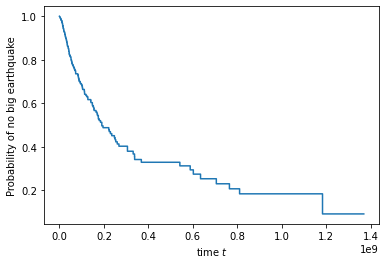

In [24]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(y_array['Status'], y_array['Time_to_event'])
plt.step(time, survival_prob, where='post')
plt.ylabel('Probability of no big earthquake')
plt.xlabel('time $t$')

It looks like most of the big events happened within .35*10^9 seconds (~11 years).

Now, for an initial test, let's train a Cox’s proportional hazard’s model and check the concordance index, which is a measure of rank correlation between predicted risk scores and observed time points.

In [25]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In [26]:
from sksurv.metrics import concordance_index_censored as ci

y_tr_pred = estimator.predict(X_train)
y_ts_pred = estimator.predict(X_test)
train_ci = ci(y_train['Status'], y_train['Time_to_event'], y_tr_pred)
test_ci = ci(y_test['Status'], y_test['Time_to_event'], y_ts_pred)

print('Concordance index on train set:', train_ci[0])
print('The number of concordant pairs on train set:', train_ci[1])
print('The number of discordant pairs on train set:', train_ci[2])
print('\nConcordance index on test set:', test_ci[0])
print('The number of concordant pairs on test set:', test_ci[1])
print('The number of discordant pairs on test set:', test_ci[2])

Concordance index on train set: 0.9657763584874803
The number of concordant pairs on train set: 112201
The number of discordant pairs on train set: 3976

Concordance index on test set: 0.8390528483184626
The number of concordant pairs on test set: 4890
The number of discordant pairs on test set: 938


Basically what we see here is that our model is doing not so bad in classifying pairs. This means that in the test set, 83% of the pairs where ordered correctly as concordant. This only means that if we consider a concordant pair of events, the one with higher estimated risk score has a shorter actual survival time. 

The problem when using this metric (__concordance_index_censored__) is that for high censored data, it overestimates the result. Our data is highly right-censored, so we need an alternative metric. In this case we use a different metric, which is __concordance_index_ipcw__. Let's check how much different is the result with this metric using the same estimator (CoxPHSurvivalAnalysis). 

In [27]:
from sksurv.metrics import concordance_index_ipcw as cip

y_ts_pred = estimator.predict(X_test)
test_cip = cip(y_train, y_test, y_ts_pred)

print('Concordance index:', test_cip[0])
print('The number of concordant pairs', test_cip[1])
print('The number of discordant pairs', test_cip[2])

Concordance index: 0.7664229025175605
The number of concordant pairs 4890
The number of discordant pairs 938


We see that the concordance index decreased from the previous result. We can interpret this as an over estimate in the first calculation. From this point on, we will use the concordance_index_ipcw metric to evaluate other model's performance. 

Now let's check how is our model doing in terms of identifying events (earthquakes >= M6.0) within a certain time, or after it. We plot the cumulative dynamic AUC to find out. 

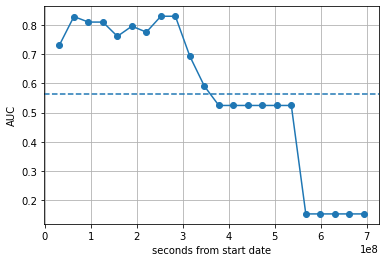

In [28]:
#code adapted from https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html
from sksurv.metrics import cumulative_dynamic_auc

time_range = np.arange(86428, 705666283, 31536000)
#We use the predict method which on this model only returns a time-independent risk score.
#This is the limitation of this model which does not return a time-dependent risk function.
scores = estimator.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, scores, time_range
)

cph_mean_auc = cph_auc[~np.isnan(cph_auc)].mean()

plt.plot(time_range, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel('seconds from start date')
plt.ylabel('AUC')
plt.grid(True)

We see that our model clearly does not do a good job, with a mean of ~ 57% (almost like a random model), at identifying big events (earthquakes >= M6.0) by a given time from  big events after this time. In our case, our model performs much better with a time threshold of ~ 3*10^8 seconds (~ 9.5 years).

Now let's try to do a similar experiment with a random survival forest model and compare the results with our previous model.

In [29]:
from sksurv.ensemble import RandomSurvivalForest

rsf = RandomSurvivalForest(random_state=0)
rsf.fit(X_train, y_train)

RandomSurvivalForest(random_state=0)

In [30]:
y_ts_pred = rsf.predict(X_test)
test_cip = cip(y_train, y_test, y_ts_pred)

print('Concordance index:', test_cip[0])
print('The number of concordant pairs', test_cip[1])
print('The number of discordant pairs', test_cip[2])

Concordance index: 0.8452042784495192
The number of concordant pairs 5553
The number of discordant pairs 275


We can see clearly that the concordance index in the random survival forest (rsf) model is much better than the Cox’s proportional hazard’s model. Let's now plot the AUC for both models and compare them.

In [31]:
#In the rsf model we can return a time-dependent risk function by using the predictive_cumulative_hazard_function method.
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(time_range) for chf in rsf_chf_funcs])
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, rsf_risk_scores, time_range
)

rsf_mean_auc = rsf_auc[~np.isnan(rsf_auc)].mean()

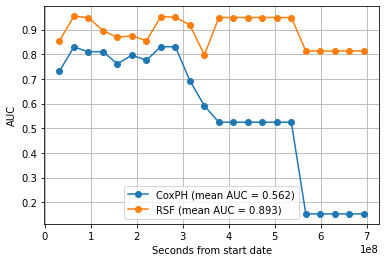

In [32]:
plt.plot(time_range, cph_auc, 'o-', label="CoxPH (mean AUC = {:.3f})".format(cph_mean_auc))
plt.plot(time_range, rsf_auc, 'o-', label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.xlabel('Seconds from start date')
plt.ylabel('AUC')
plt.legend(loc="lower center")
plt.grid(True)

There is a very big difference in the performance of both models. Clearly the random survival forest model outperforms the Cox's proportional hazards one. So we will decide for the rsf model and try to see if, by applying cross validation and gridsearch, we can improve more its results.  

In the next step, we will check if we can improve even more the performance of the rsf model, by doing a randomized search and selecting the model with the best hyperparameters

In [33]:
#We will use a function to create a distribution for integer values
#Code adapted from: https://github.com/INRIA/scikit-learn-mooc/blob/main/notebooks/parameter_tuning_randomized_search.ipynb
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [34]:
#We do a 5 splits cross validation
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=0)

In [35]:
%%time
#We use randomized search to try to get the best hyperparameters and reduce the computational time
#We will try to optimize the values for the 'max_depth' and 'n_estimators' hyperparameters
from sklearn.model_selection import RandomizedSearchCV

rsf = RandomSurvivalForest(random_state=0)
param_distributions = {
    'max_depth': loguniform_int(1, 10),
    'n_estimators': loguniform_int(100, 300)
}

rsf_random_search = RandomizedSearchCV(
    rsf, param_distributions=param_distributions, n_iter=10,
    cv=cv, verbose=1, n_jobs=-1,
)
rsf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 9min 59s, sys: 1.36 s, total: 10min
Wall time: 1h 43min 44s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=RandomSurvivalForest(random_state=0), n_jobs=-1,
                   param_distributions={'max_depth': <__main__.loguniform_int object at 0x7fb3be677340>,
                                        'n_estimators': <__main__.loguniform_int object at 0x7fb3be6776a0>},
                   verbose=1)

In [36]:
rsf_best = rsf_random_search.best_estimator_
print('The best model is:', rsf_best)

The best model is: RandomSurvivalForest(max_depth=7, n_estimators=248, random_state=0)


After the randomized search for the best hyperparameters, we ended with a model with a __max_depth=7__ and __n_estimators=248__. It took 1 hour and 44 minutes to fit this model with the search. Let's see if this optimized model performs better than the default rsf model. 

In [37]:
y_ts_pred = rsf_best.predict(X_test)
test_cip = cip(y_train, y_test, y_ts_pred)

print('Concordance index:', test_cip[0])
print('The number of concordant pairs', test_cip[1])
print('The number of discordant pairs', test_cip[2])

Concordance index: 0.8296177644806861
The number of concordant pairs 5261
The number of discordant pairs 567


We see that this "optimized" model does a little worse than the standard rsf model. Now, let's see how the AUC plot looks like.

In [38]:
rsf_chf_funcs = rsf_best.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(time_range) for chf in rsf_chf_funcs])
rsf_best_auc, rsf_best_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, rsf_risk_scores, time_range
)

rsf_best_mean_auc = rsf_best_auc[~np.isnan(rsf_best_auc)].mean()

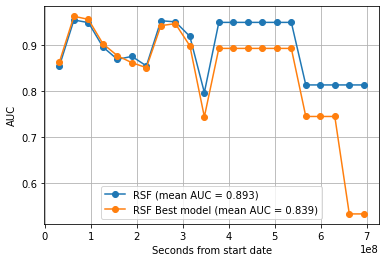

In [39]:
plt.plot(time_range, rsf_auc, 'o-', label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.plot(time_range, rsf_best_auc, 'o-', label="RSF Best model (mean AUC = {:.3f})".format(rsf_best_mean_auc))
plt.xlabel('Seconds from start date')
plt.ylabel('AUC')
plt.legend(loc="lower center")
plt.grid(True)

Just as we expected, the "optimized" rsf model performs worse than the standard one, especially after ~ 3*10^8 seconds (~ 9.5 years). In this case we will stick with the standard rsf model. Now, let's try yet, another model. The Gradient Boosting Survival model (gbs). First we will check the concordance index on a standard gbs model.

In [40]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

gbs = GradientBoostingSurvivalAnalysis(random_state=0)
gbs.fit(X_train, y_train)
y_ts_pred = gbs.predict(X_test)
test_cip = cip(y_train, y_test, y_ts_pred)

print('Concordance index:', test_cip[0])
print('The number of concordant pairs', test_cip[1])
print('The number of discordant pairs', test_cip[2])

Concordance index: 0.8116909175144893
The number of concordant pairs 5531
The number of discordant pairs 285


We see that the gbs model is worse than any of the rsf models. Let's try to optimize this model too by using randomized search. The hyperparameters that we will try to optimize are 'learning_rate' and 'n_estimators'.

In [41]:
%%time

param_distributions = {
    'learning_rate': loguniform(0.01, 1),
    'n_estimators': loguniform_int(100, 300)
}

gbs_random_search = RandomizedSearchCV(
    gbs, param_distributions=param_distributions, n_iter=10,
    cv=cv, verbose=1, n_jobs=-1,
)
gbs_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 9min 2s, sys: 900 ms, total: 9min 2s
Wall time: 1h 53min 34s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=GradientBoostingSurvivalAnalysis(random_state=0),
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb3dd6b4220>,
                                        'n_estimators': <__main__.loguniform_int object at 0x7fb3dd6e3550>},
                   verbose=1)

In [42]:
gbs_best = gbs_random_search.best_estimator_
print('The best model is:', gbs_best)

The best model is: GradientBoostingSurvivalAnalysis(learning_rate=0.01877770996241165,
                                 n_estimators=216, random_state=0)


We have a best gbs model with a __'learning_rate'=0.019__ and __'n_estimators'=216__. It took 1 hour and 54 minutes to fit this model with the search. Let's now check the index on the optimized gbs model.

In [43]:
y_ts_pred = gbs_best.predict(X_test)
test_cip = cip(y_train, y_test, y_ts_pred)

print('Concordance index:', test_cip[0])
print('The number of concordant pairs', test_cip[1])
print('The number of discordant pairs', test_cip[2])

Concordance index: 0.8197443051877237
The number of concordant pairs 5536
The number of discordant pairs 247


In this case, the optimized model performs just a little better than the standard gbs model. Now, same as we did with the rsf model, let's see how the AUC plot looks like.

In [65]:
gbs_chf_funcs = gbs_best.predict_cumulative_hazard_function(X_test)
gbs_risk_scores = np.row_stack([chf(time_range) for chf in gbs_chf_funcs])
gbs_auc, gbs_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, gbs_risk_scores, time_range
)

gbs_mean_auc = gbs_auc[~np.isnan(gbs_auc)].mean()

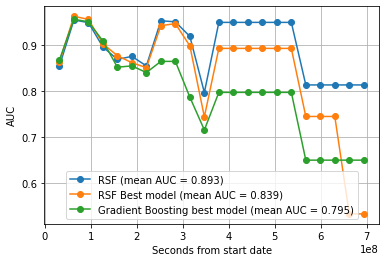

In [66]:
plt.plot(time_range, rsf_auc, 'o-', label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.plot(time_range, rsf_best_auc, 'o-', label="RSF Best model (mean AUC = {:.3f})".format(rsf_best_mean_auc))
plt.plot(time_range, gbs_auc, 'o-', label="Gradient Boosting best model (mean AUC = {:.3f})".format(gbs_mean_auc))
plt.xlabel('Seconds from start date')
plt.ylabel('AUC')
plt.legend(loc="lower center")
plt.grid(True)

We can compare now the best 3 models we found. It is interesting to see that still, the best model is the standard rsf model. Perhaps we could have done a deeper search for best hyperparameters and try to get an even higher index score. But, for now, we will stick with the default rsf model, since its index score is not bad.

As a final comparison we will calculate the brier score on these 3 models and see which one has the best score. The brier score is the equivalent for mean squared error in regression. Since this is an error score, we want it to be as low as possible. Let's evaluate the 3 models.

In [67]:
from sksurv.metrics import integrated_brier_score

#We get the survival function from all 3 models
survs_rsf = rsf.predict_survival_function(X_test)
survs_rsf_best = rsf_best.predict_survival_function(X_test)
survs_gbs = gbs_best.predict_survival_function(X_test)

#Now we get the time-dependent functions in an array, for our time range. 
preds_rsf = np.asarray([[fn(t) for t in time_range] for fn in survs_rsf])
preds_rsf_best = np.asarray([[fn(t) for t in time_range] for fn in survs_rsf_best])
preds_gbs = np.asarray([[fn(t) for t in time_range] for fn in survs_gbs])


score_rsf = integrated_brier_score(y_train, y_test, preds_rsf, time_range)
score_rsf_best = integrated_brier_score(y_train, y_test, preds_rsf_best, time_range)
score_gbs = integrated_brier_score(y_train, y_test, preds_gbs, time_range)

print(pd.DataFrame([score_rsf, score_rsf_best, score_gbs], index=['Random Forest', 'Random Forest (Best)', 'Gradient Boosting'], columns=['Integrated Brier Score']))

                      Integrated Brier Score
Random Forest                       0.106263
Random Forest (Best)                0.108516
Gradient Boosting                   0.119945


We see that even in evaluating the Integrated Brier Score (IBS), the rsf model performs the best.<br>
Based on all of these results, we will decide for the rsf model.

As a final step, we will perform some predictions using the rsf model.<br><br>
First, we will choose 5 different samples from the test set which have different classes.

In [49]:
#These 5 samples have different 'State', 'Plate', 'Magnitude' values, among others.
X_test.iloc[[241, 342, 358, 388, 1890]]

,Month=10,Month=11,Month=12,Month=2,Month=3,Month=4,Month=5,Month=6,Month=7,Month=8,...,State=SON,State=TAB,State=TAMS,State=TLAX,State=VER,State=YUC,State=ZAC,Plate=north_america,Plate=pacific,Plate=rivera
12308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17012,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17020,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15606,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
#We create another variable to avoid affecting our original dataset.
sample_df = quakes_data.reset_index()
#We look for the index values of the 5 samples shown in the previous cell.
sample_df = sample_df[sample_df['index'].isin([12308, 17012, 17020, 15606, 1501])]
#We order the samples in the most convenient way for us to visualize them.
sample_df.iloc[[1,3,4,2,0]]
#We will use this new dataframe only to visualize the information on our 5 samples.

,index,Date_Time,Year,Month,Day,Magnitude,Latitude,Longitude,Depth,State,Plate,Status,Time_to_event
7902,12308,2006-07-12 03:54:24,2006,7,12,4.2,14.7300,-94.020,43.0,CHIS,cocos,0,194367.0
10421,17012,2012-04-11 17:55:10,2012,4,11,6.4,17.9217,-103.068,20.0,MICH,cocos,1,368363603.0
10424,17020,2012-04-12 02:05:59,2012,4,12,6.0,28.7955,-113.414,15.0,BCS,pacific,1,14067241.0
9720,15606,2010-10-21 12:53:11,2010,10,21,6.5,24.6500,-109.410,8.0,BCS,pacific,1,99009531.0
1173,1501,1985-09-20 19:37:14,1985,9,20,7.6,17.8280,-101.681,17.0,GRO,cocos,1,38522802.0


As we see, our 5 samples contain examples of 'Status'=0 and 1. Also, we have 2 samples of the same 'State' and 'Plate'. Now let's check first, the risk score for each of our samples.

In [69]:
pd.Series(rsf.predict(X_test.iloc[[241, 342, 358, 388, 1890]]))

0     34.790634
1     63.907534
2     77.010092
3     71.326115
4    107.614440
dtype: float64

The sample with the highest magnitude in the GRO (Guerrero) State has the highest risk factor. It is interesting to see that between the two samples with the same 'State' and 'Plate' values, our model predicts a bigger risk factor for the event with a magnitude of 6.0 than the one with 6.5.

Finally, we will plot the survival function for each of our samples and check if the results are what we expect.

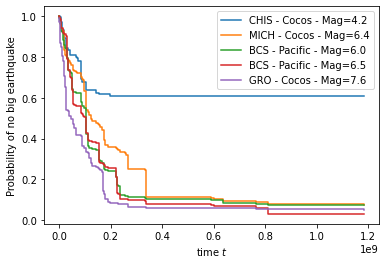

In [54]:
i = 0
#We define more informational labels for each plotted line
labels = ['CHIS - Cocos - Mag=4.2', 'MICH - Cocos - Mag=6.4', 'BCS - Pacific - Mag=6.0', 'BCS - Pacific - Mag=6.5', 'GRO - Cocos - Mag=7.6']
survs = rsf.predict_survival_function(X_test.iloc[[241, 342, 358, 388, 1890]])
for fn in survs:
    plt.ylabel('Probability of no big earthquake')
    plt.xlabel('time $t$')
    plt.step(fn.x, fn(fn.x), where="post", label=labels[i])
    plt.legend()
    i += 1

In the previous plot, we see that the blue line has the highest survival probability of no big earthquake. This totally aggrees with what we expected, since this event is an event of Magnitude = 4.2, meaning a no-big-earthquake event with 'Status' = 0.<br><br>
Another interesting point is that the lowest survival probability event is the one with Magnitude = 7.6. This means that we might expect for an event like this to have ~ 90% probability to happen within 0.2*10^9 seconds(~ 6.3 years) from the last event in the same State and Magnitude >= 6.0. Both events in BCS (Baja California Sur) look similar, but either of them, has higher risk than the one in MICH (Michoacan).

__Conclusion:__<br><br>
In this notebook, we took the clean dataframe that we had, and considered that insights that we obtained in previous steps. We added important features to our data and set up our label data 'y' for a "Survival Analysis" treatment and modelling.<br><br>

We checked 5 models in total and during each step, we confirmed that the best model for us was the Random Survival Forest standard model.<br><br>

We applied the model to 5 samples and tried to obtain insights from the predictions. We confirmed that the model gave us reasonable results by seeing that the sample with a no-big-earthquake class ('Status' = 0) gave us a very high and stable survival probability that went out-of-scope in our time range.<br>On the other hand, the rest of the samples, had a more similar survival probability curve. Looking at the results, we might expect that any of the 4 samples' events happen within 6 and 12 years with a ~ 90% probability.